# Test DECiSION
Use a trained U-Net model created using `DECiSION_train.ipynb` to predict segmentation maps for MRI images.

## Import packages

In [1]:
import DECiSION_settings as settings
from thesis_common import read_images, read_groundtruths,\
    convert_pred_to_img, group_images, show_image, create_hdf5_db

from dltoolkit.utils.generic import list_images
from dltoolkit.nn.segment import UNet_NN
from dltoolkit.utils.visual import plot_roc_curve, plot_precision_recall_curve,\
    print_confusion_matrix, print_classification_report

import os, cv2, shutil, time
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

/Users/geoff/anaconda3/envs/ML3-DL-OPENCV/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Determine how to test
Set `IS_INFERENCE` to `False` to use a trained model to create segmentation maps for test MRI images for which ground truths are available. This is typically used to obtain a final test error estimate at the very end of the training process. Set it to `False` to use a trained model for MRI images for which ground truths are not available, i.e. simulating a production scenario.

During development set `IS_DEVELOPMENT` to `True` to always use the training data set. 

In [2]:
IS_INFERENCE = False
IS_DEVELOPMENT = True

## Path to the trained model to load
Enter the full path to the saved trained model here.

In [3]:
TRAINED_MODEL_NAME = "../savedmodels/DECiSION_UNet_brain_3layer_BN_ep100.model"
# TRAINED_MODEL_NAME = "../savedmodels/DECiSION_UNet_brain_4layer_BN_ep100.model"

## Convert test data to HDF5
The first function `perform_hdf5_conversion_test()` converts data in the `test` folder to HDF5. Data comprises MRI images as well as their ground truths. This function is used to apply a trained model to MRI images for which ground truths are available so that various performance metrics can be calculated.

The second function `perform_hdf5_conversion_inference()` does the same but does not include ground truths. It is used to apply a trained model to MRI images for which ground truths are not available.

Note: during development and pipeline testing neither function is used. Instead, the training/validation set is used, the same sets used to train the model.

In [4]:
def perform_hdf5_conversion_test(settings):
    # Prepare the path to the TEST images AND ground truths. Note that the data is NOT shuffled.
    img_exts = ".jpg"
    img_path = os.path.join(settings.TEST_PATH, settings.FLDR_IMAGES)
    msk_path = os.path.join(settings.TEST_PATH, settings.FLDR_GROUND_TRUTH)

    # Create a list of paths to the individual patient folders
    patient_fld_imgs = sorted([os.path.join(img_path, e.name) for e in os.scandir(img_path) if e.is_dir()])
    patient_fld_masks = sorted([os.path.join(msk_path, e.name) for e in os.scandir(msk_path) if e.is_dir()])

    # Obtain a list of paths to the test images and ground truths for each patient
    img_list = []
    msk_list = []
    for patient_ix, (p_fld_imgs, p_fld_masks) in enumerate(zip(patient_fld_imgs, patient_fld_masks)):
        img_list.extend(sorted(list(list_images(basePath=p_fld_imgs,
                                                validExts=img_exts)))
                        [settings.SLICE_START:settings.SLICE_END])
        msk_list.extend(sorted(list(list_images(basePath=p_fld_masks,
                                                validExts=img_exts)))
                        [settings.SLICE_START:settings.SLICE_END])

    assert(len(img_list) == len(msk_list))

    # Create the HDF5 data sets
    output_paths = []

    # Test images
    output_paths.append(create_hdf5_db(img_list, "test", img_path,
                                       (settings.IMG_HEIGHT, settings.IMG_WIDTH, settings.IMG_CHANNELS),
                                       key=settings.HDF5_KEY, ext=settings.HDF5_EXT, settings=settings))

    # Test ground truths
    output_paths.append(create_hdf5_db(msk_list, "test", msk_path,
                                       (settings.IMG_HEIGHT, settings.IMG_WIDTH, settings.IMG_CHANNELS),
                                       key=settings.HDF5_KEY, ext=settings.HDF5_EXT, settings=settings,
                                       is_mask=True))
    
    return output_paths

def perform_hdf5_conversion_inference(settings):
    # Prepare the path to the TEST images (NO ground truths because they are not available)
    img_exts = ".jpg"
    test_path = os.path.join(settings.TEST_PATH, settings.FLDR_IMAGES)

    # Create a list of paths to the individual patient folders
    test_imgs = sorted(list(list_images(basePath=test_path,
                                        validExts=img_exts)))[settings.SLICE_START:settings.SLICE_END]

    # Create the HDF5 data sets
    output_paths = []

    # Test images (no ground truths available, no need to split). The assumption is only
    # relevant images are placed in the test folder, i.e. the pipeline will not exclude
    # any slices
    output_paths.append(create_hdf5_db(test_imgs, "test", test_path,
                                        (settings.IMG_HEIGHT, settings.IMG_WIDTH, settings.IMG_CHANNELS),
                                        key=settings.HDF5_KEY, ext=settings.HDF5_EXT, settings=settings))

    return output_paths

In [5]:
if IS_DEVELOPMENT:
    print("Development mode, no test set created. Use the training/validation set.")
else:
    if IS_INFERENCE:
        output_paths = perform_hdf5_conversion_inference(settings)
        print("Converted test images WITHOUT ground truths for inference: {}".format(output_paths))
    else:
        output_paths = perform_hdf5_conversion_test(settings)
        print("Converted test images WITH ground truths for model estimate: {}".format(output_paths))

Development mode, no test set created. Use the training/validation set.


## Load data
The cell below performs the actual loading of data. The assumption is that all test data fit into memory, generators are NOT used.

In [6]:
# Load the images and ground truths
if IS_DEVELOPMENT:
    # Use training images for pipeline validation and training
    print("WARNING: using TRAINING images, NOT TEST images for PIPELINE DEVELOPMENT")
    test_imgs = read_images("../data/MSC8002/training/train_images.h5", settings.HDF5_KEY)
    test_ground_truths = read_groundtruths("../data/MSC8002/training/train_groundtruths.h5", settings.HDF5_KEY)
else:
    if IS_INFERENCE:
        print("--- Pre-processing test images without ground truths for INFERENCE")
        # Use for inference on test images without ground truths
        test_imgs = read_images(output_paths[0], settings.HDF5_KEY)
    else:
        # Use test images WITH ground truths for final model evaluation
        print("WARNING: using TEST images, NOT TRAINING images for MODEL EVALUATION")
        test_imgs = read_images(output_paths[0], settings.HDF5_KEY)
        test_ground_truths = read_groundtruths(output_paths[1], settings.HDF5_KEY)

Loading image HDF5: ../data/MSC8002/training/train_images.h5 with dtype = float16
Loading ground truth HDF5: ../data/MSC8002/training/train_groundtruths.h5 with dtype = uint8


## Show one image to check
Show a single image and, if available, its ground truth just as a check.

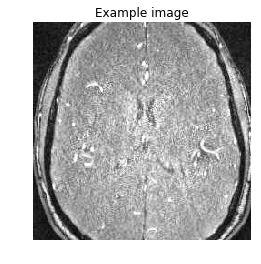

       Max image intensity: 1.0 - float16 - (259, 240, 240, 1)


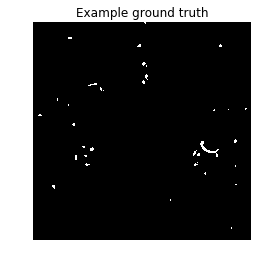

Max ground truth intensity: 255 - uint8 - (259, 240, 240, 1)


In [7]:
# Show an image plus its ground truth to check
IX = 0
show_image(np.squeeze(test_imgs[IX]), 'Example image')

print("       Max image intensity: {} - {} - {}".format(np.max(test_imgs[IX]), test_imgs.dtype, test_imgs.shape))
if not IS_INFERENCE or IS_DEVELOPMENT:
    show_image(np.squeeze(test_ground_truths[IX]), 'Example ground truth')
    print("Max ground truth intensity: {} - {} - {}".format(np.max(test_ground_truths[IX]),
                                                            test_ground_truths.dtype,
                                                            test_ground_truths.shape))

## Load the trained model
Load the saved in the location specified by `TRAINED_MODEL_NAME`. Use the appropriate variant of the `build_model_XXX()`. Keras is unable to load a model when a different architecture has been loaded.

In [8]:
# Create the UNet model and load its saved weights
unet = UNet_NN(img_height=settings.IMG_HEIGHT,
               img_width=settings.IMG_WIDTH,
               img_channels=settings.IMG_CHANNELS,
               num_classes=settings.NUM_CLASSES)
model = unet.build_model_BRAIN_3layer(use_bn=True, use_dropout=False)
# model = unet.build_model_BRAIN_4layer(use_bn=True, use_dropout=False)
model.load_weights(TRAINED_MODEL_NAME)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 240, 240, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 240, 240, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 240, 240, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 240, 240, 32) 9248        batch_normalization_1[0][0]      
__________________________________________________________________________________________________
batch_norm

## Predict segmentation maps
The single line below predicts segmentation maps for all MRI images in the `test_imgs` array.

In [9]:
start_time = time.time()
print("Number of samples: {}".format(test_imgs.shape))
predictions = model.predict(test_imgs, batch_size=settings.TRN_BATCH_SIZE, verbose=2)
print("Elapsed time: {:.2f}s".format(time.time() - start_time))

Number of samples: (259, 240, 240, 1)
Elapsed time: 57.68s


## Convert predictions to segmentation map images
This cell converts the predictions (i.e. scores for both classes for each pixel) into an images that can be displayed later. A threshold `TRN_PRED_THRESHOLD` is used to determine whether a pixel should be assigned the background or blood vessel class.

In [10]:
predictions_imgs = convert_pred_to_img(predictions,
                                       threshold=settings.TRN_PRED_THRESHOLD,
                                       verbose=settings.VERBOSE)

Elapsed time: 0.92s


## Show segmentation maps
Display a single MRI image, its ground truth (if available) and the predicted segmentation map. In addition, save a number of images, ground truths and segmentation maps into a single image (one for each type) for visualization.

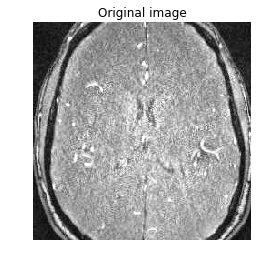

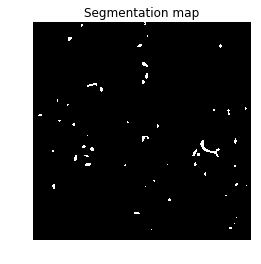

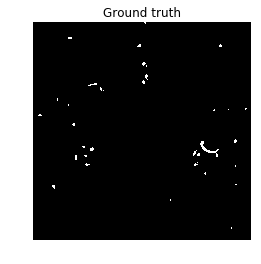

  gr truth 255 dtype uint8
  original 1.0 dtype float16
prediction 255 dtype uint8


In [11]:
# Show a single image, ground truth and segmentation map
MAX_IMAGES = len(predictions_imgs)
show_image(np.squeeze(test_imgs[0]), 'Original image')
show_image(np.squeeze(predictions_imgs[0]), 'Segmentation map')

if not IS_INFERENCE or IS_DEVELOPMENT:
    show_image(np.squeeze(test_ground_truths[0]), 'Ground truth')

    # Plot a number of ground truths in a single image 
    group_images(test_ground_truths[0:min(16, MAX_IMAGES)],
                 4, 1.0, False, "../output/DECISION_"+unet.title+"_grp_originals")
    
    print("  gr truth {} dtype {}".format(np.max(test_ground_truths[0]), test_ground_truths[0].dtype))

# Plot images and segmentation maps in a single images
group_images(test_imgs[0:min(16, MAX_IMAGES)],
             4, 1.0, False, "../output/DECISION_" + unet.title+"_grp_images")
group_images(predictions_imgs[0:min(16, MAX_IMAGES)],
             4, 1.0, False, "../output/DECISION_" + unet.title+"_grp_predictions")

print("  original {} dtype {}".format(np.max(test_imgs[0]), test_imgs[0].dtype))
print("prediction {} dtype {}".format(np.max(predictions_imgs[0]), predictions_imgs[0].dtype))

## Show metrics
The cells below produxe a number of metrics for the current model and the segmentation maps it produced.

### ROC curve


Area under ROC curve: 0.9984876933557619


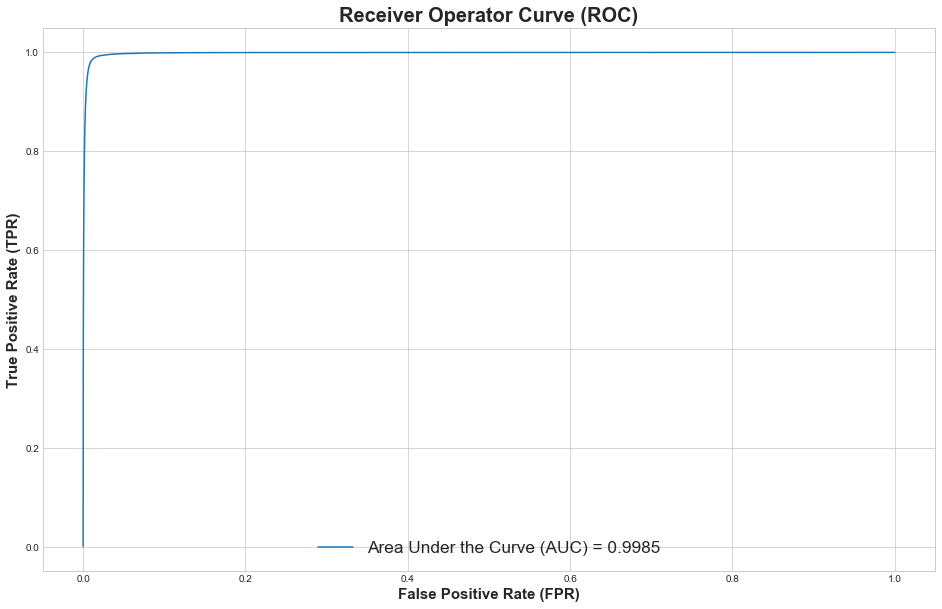

In [12]:
if not IS_INFERENCE or IS_DEVELOPMENT:
    roc_path = os.path.join(settings.OUTPUT_PATH, "DECiSION_" + unet.title)
    plot_roc_curve(test_ground_truths, predictions[:,:,:,1], show=True, save_path=roc_path)

### Precision/recall curve


Area under Precision-Recall curve: 0.8284339048476326


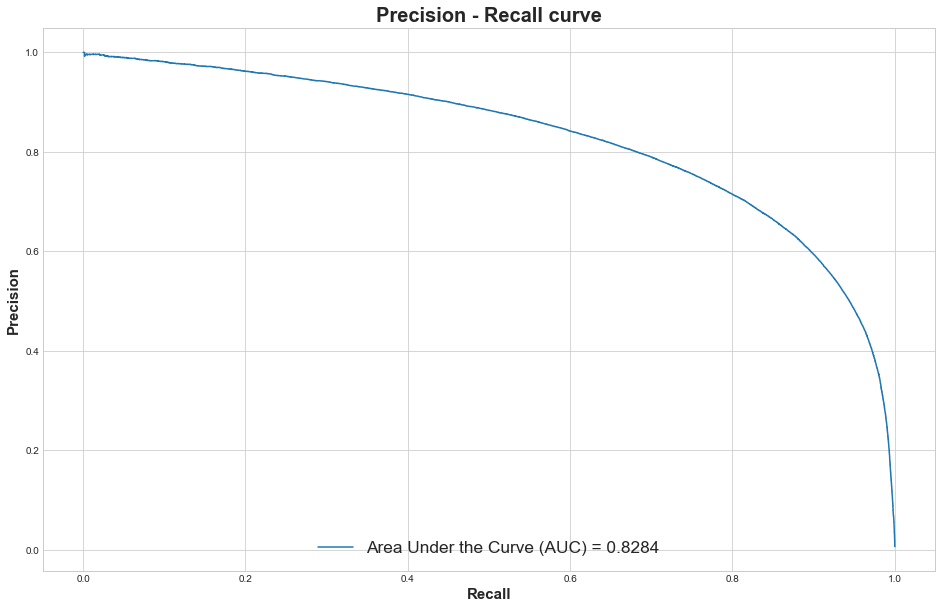

In [13]:
if not IS_INFERENCE or IS_DEVELOPMENT:
    prec_path = os.path.join(settings.OUTPUT_PATH, "DECiSION_" + unet.title)
    plot_precision_recall_curve(test_ground_truths, predictions, settings.NUM_CLASSES, show=True, save_path=prec_path)

### Confusion matrix

In [14]:
if not IS_INFERENCE or IS_DEVELOPMENT:
    (conf_ind, conf_mat) = print_confusion_matrix(test_ground_truths, predictions_imgs)

Confusion matrix:
[[14767500    75932]
 [    3767    71201]]
   Row/Column: Negative Class, Positive Class, i.e.:
             TN FP
             FN TP

 True Negative (TN): 14767500
 True Positive (TP): 71201
False Negative (FN): 3767
False Positive (FP): 75932

Blood vessel precision: 0.48
   Blood vessel recall: 0.95


### Classification report

In [15]:
if not IS_INFERENCE or IS_DEVELOPMENT:
    print_classification_report(test_ground_truths, predictions_imgs)

Precision: 0.48
   Recall: 0.95
             precision    recall  f1-score   support

 background       1.00      0.99      1.00  14843432
     vessel       0.48      0.95      0.64     74968

avg / total       1.00      0.99      1.00  14918400



## Write segmentation maps, ground truths and MRI images
Finally the predicted segmentation maps, ground truths (after applying the binary mask) and orignal MRI images are all saved to disk. Note: the training/validation sets are shuffled by `DECiSION_train.ipynb`. If they are used by this notebook the order in which the images are saved to disk will be different than the original order (i.e. they will not start at the neck moving up to the top of the skull). The segmentation map, ground truth and MRI images association IS however respected.

In [16]:
# Remove existing files
SEGMAP_PATH = "../output/segmentation_maps/"
if os.path.exists(SEGMAP_PATH):
    shutil.rmtree(SEGMAP_PATH)
os.makedirs(SEGMAP_PATH)

In [17]:
for i in range(len(predictions_imgs)):
    cv2.imwrite(SEGMAP_PATH + "segmap_{}.jpg".format(i), predictions_imgs[i], (cv2.IMWRITE_JPEG_QUALITY, 100))

In [18]:
if not IS_INFERENCE or IS_DEVELOPMENT:
    for i in range(len(test_ground_truths)):
        cv2.imwrite(SEGMAP_PATH + "groundtruth_{}.jpg".format(i), test_ground_truths[i], (cv2.IMWRITE_JPEG_QUALITY, 100))

In [19]:
for i in range(len(test_imgs)):
    cv2.imwrite(SEGMAP_PATH + "image_{}.jpg".format(i), test_imgs[i].astype(np.float32)*255, (cv2.IMWRITE_JPEG_QUALITY, 100))

## Testing complete